# Self Guided DIP Implementation for MRXCAT Data (Study-II):

### Import libraries and utilities:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import torch
import torch.optim as optim
import torch.fft as fft
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
# from tqdm.notebook import tqdm
import sigpy as sp
# import sigpy.mri as mr
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
import pickle
import glob
# from models import skip
#from DIP_UNET_models.skip import skip
from models import UNet, FullUNet, MediumUNet, OneLayerUNet, ExtraDeepUNet, SuperDeepUNet
from utils.common_utils import *
from utils.fftc import * # ra: added the pytorch fft routine from fastmri


/home/ahmad.sultan/.conda/envs/DISCUS-Sultan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check avaialble hardware:

In [2]:
# check available hardware:
def list_cuda_devices():
    if torch.cuda.is_available():
        num_devices = torch.cuda.device_count()
        print(f"Number of available CUDA devices: {num_devices}")
        for i in range(num_devices):
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")
            print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 2:.2f} MB")
            print(f"  Memory Cached: {torch.cuda.memory_reserved(i) / 1024 ** 2:.2f} MB")
            print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1024 ** 2:.2f} MB")
    else:
        print("CUDA is not available.")

list_cuda_devices()

Number of available CUDA devices: 2
Device 0: NVIDIA GeForce RTX 4090
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Total Memory: 24217.31 MB
Device 1: NVIDIA GeForce RTX 4090
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Total Memory: 24217.31 MB


## Define additional utilities:

In [3]:
# multi-coil data:
def fft_with_shifts(img):
    return fft.fftshift(fft.fft2(fft.ifftshift(img) , norm='ortho'))

def ifft_with_shifts(ksp):
    return fft.fftshift(fft.ifft2(fft.ifftshift(ksp) , norm='ortho'))

def ksp_and_mps_to_gt(ksp, mps): # multi-coil kspace and sensitivity maps to ground truth image
    gt = mps.conj() * ifft_with_shifts(ksp)
    gt = torch.sum(gt, axis=0) # axis=0 is the coil dim.
    return gt

def mps_and_gt_to_ksp(mps, gt): # maps and ground truth image to multi-coil kspace
    ksp = fft_with_shifts(mps * gt)
    return ksp


def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]

# NMSE and SSIM functions:
def compute_nmse(x, xHat): # for a batch of images: assuming 1st dimension to be Batch dimension
    nmse = 10*torch.log10(torch.mean(torch.sum((x-xHat)**2, dim=(-1,-2)) / torch.sum(x**2, dim=(-1,-2))))
    return nmse

# def compute_ssim(x, xHat):
#     batch_size = x.shape[0]
#     ssim = torch.zeros(batch_size)
#     for i in range(batch_size): # over batch dimension
#         ssim[i] = ssm(torch_to_np(x[i,:,:]), torch_to_np(xHat[i,:,:]), data_range=(xHat[i,:,:].max()-xHat[i,:,:].min()).item())
#     return torch.mean(ssim) # average over batch dimension

### Select study parameters and dataset: 

In [4]:
# select parameetrs:
R=4
FS=1
nt= 32 # ablation
# choose num of frames to run

# select dataset:
# Choose from "{"with_lesion", "without_lesion"}"
folder = "with_lesion/" # 'with_lesion' # 'without_lesion'
patient = "male_pt77/" # choose from: {'female_pt71', 'male_pt77', 'male_pt80'}
path = "../data/MRXCAT/"

data_path = path+folder+patient
if FS:
    data_path_r = data_path + "R%d/comparison/"%R

## Load simulated Data:

In [7]:
ksp = np.load(data_path_r+"yu" +"_R_%f"%R+".npy")
n = np.shape(ksp)[-2:]
(N,Nc) = np.shape(ksp)[0:2]
print("Image size: ", n)
msk = np.load(data_path_r+"mask_R_%f"%R+".npy")
maps = np.load(data_path+"sen_maps"+".npy")
nIter_=300
tau=1e-6
if FS:
    # img = np.load(data_path+"xRef_N_%d"%(N)+".npy")
    img = np.load(data_path+"xRef_N_%d_ADMMnIters_%d_tau_%f"%(N, nIter_,tau)+".npy")


ku = complex_to_real_plus_imag_4d(ksp)
if FS:
    m = complex_to_real_plus_imag_3d(img)
samp = msk
sen = complex_to_real_plus_imag_4d(np.expand_dims(np.transpose(maps,(2,0,1)),axis=0))
# sen = complex_to_real_plus_imag_4d(maps)
sen_c = np.transpose(maps, (2,0,1)) #* cc_maps_sens # corrected sen maps


Image size:  (224, 192)

Inside complex_to_real_plus_imag
(64, 8, 224, 192)
float64

Inside complex_to_real_plus_imag
(64, 224, 192)
float64

Inside complex_to_real_plus_imag
(2, 8, 224, 192)
float64


### Network:

In [8]:
# network weights initialization:
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    # print('Initialized network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


In [10]:
PLOT = 1
sv_SSDIP=1
num_epochs=1000
show_every=100
learning_rate = 3e-4#3e-4
alpha = 2e-2#2e-2 # strength of denoiser regularization
gm=1


## Select frame to reconstruct:


frame  1
Iter:  1
SSIM:  0.06978497729038788
NMSE:  -0.8131556897646158


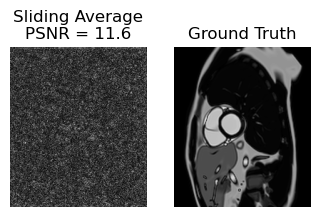

Iter:  100
SSIM:  0.788416687952277
NMSE:  -12.773147144475756


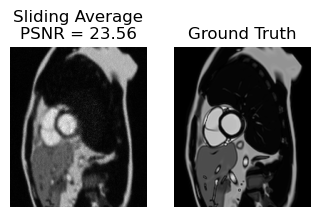

Iter:  200
SSIM:  0.9129009508410312
NMSE:  -15.637944919799045


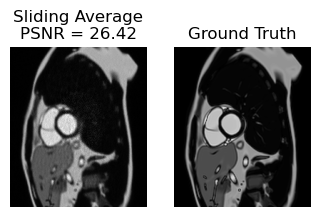

Iter:  300
SSIM:  0.9607302900958832
NMSE:  -16.629303183047263


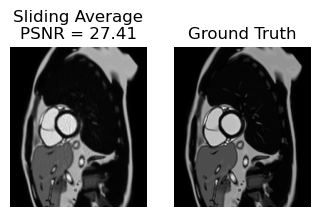

Iter:  400
SSIM:  0.9811179585250454
NMSE:  -20.784298138087717


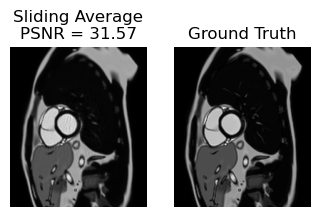

Iter:  500
SSIM:  0.9851560297561984
NMSE:  -23.364937074851145


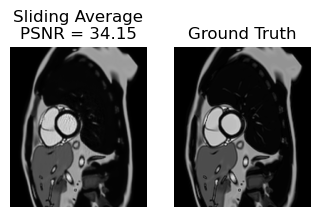

Iter:  600
SSIM:  0.9820208776867568
NMSE:  -18.521327321423055


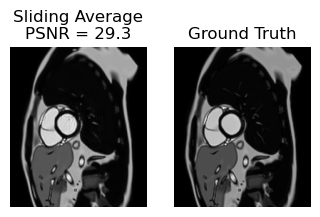

Iter:  700
SSIM:  0.9824810865179667
NMSE:  -18.637684087160693


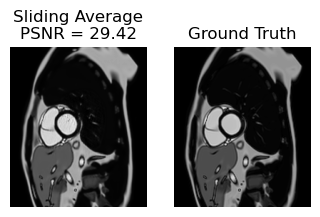

Iter:  800
SSIM:  0.9808268766925228
NMSE:  -18.04378438010786


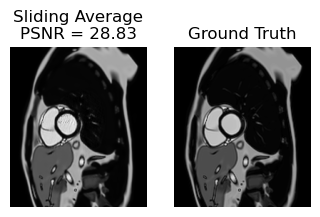

Iter:  900
SSIM:  0.9854545647025525
NMSE:  -21.6925494977488


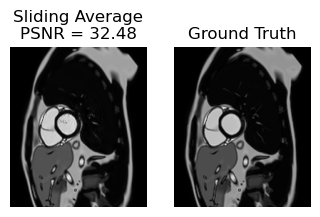

Iter:  1000
SSIM:  0.9875751793484625
NMSE:  -25.708858880260323


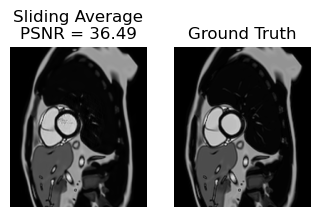

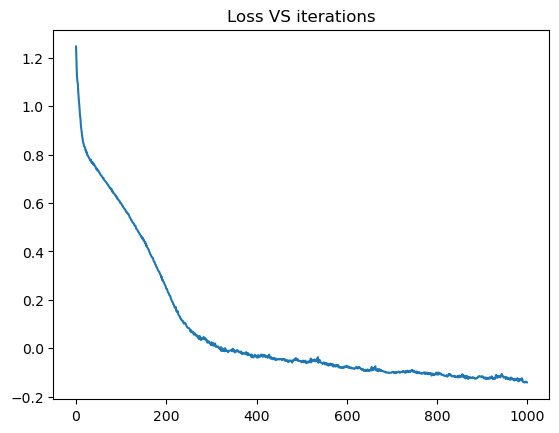

SSIM:  0.9875751793484594
NMSE:  -25.708858880260323


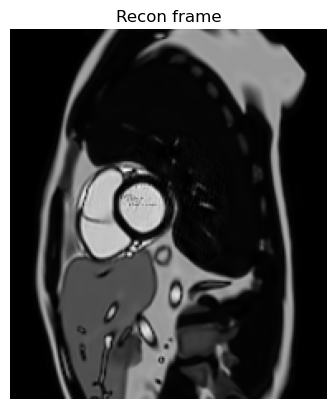


frame  2
Iter:  1
SSIM:  0.08055521981116918
NMSE:  -1.024624130617004


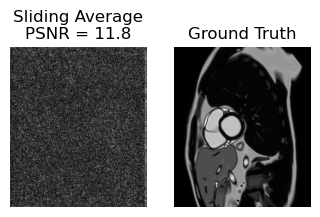

Iter:  100
SSIM:  0.7263189298583063
NMSE:  -13.124770061131114


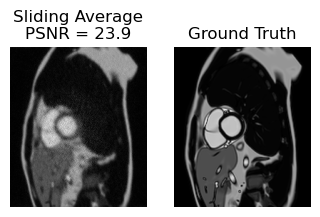

KeyboardInterrupt: 

In [12]:

xHat_SSDIP = np.zeros((2*N,n[0],n[1]))
# SSDIP_ksp_sc = np.zeros((1, N))
# sen_msk_to = np_to_torch(sen_msk).to(device)

for i in range(N): #N 
    # i=3 # 4th frame
    print("\nframe ", i+1)  
    ## noisy kspace
    ksp_u = torch.zeros(1,Nc,n[0],n[1], dtype=torch.complex64) # complex
    # ksp_gt = torch.zeros(1,1,n[0],n[1], dtype=torch.complex64) # complex
    ksp_u[0,:,:,:] = np_to_torch(ksp[i,:,:,:]) # undersampled kspace
    ## ground truth kspace
    # ksp_gt[0,0,:,:] = np_to_torch(yN[2*i,:,:]) + 1j*np_to_torch(yN[2*i+1,:,:])
    gt = np_to_torch(img[i,:,:])
    # print(gt.shape, gt.dtype)

    # 2nd optimizer for refernce: flexible w.r.t. LR
    ref = Variable(torch.rand((1,2,n[0],n[1])), requires_grad=True)
    optimizer2 = optim.Adam([ref], lr = 1e-1)

    net = ExtraDeepUNet(n_channels=2, n_classes=2)
    #net= nn.DataParallel(net).to(device)
    init_weights(net, init_type='normal',init_gain=0.02)
    optimizer = optim.Adam(net.parameters(), lr = learning_rate)


    # data normalization
    with torch.no_grad():
        scale_factor = torch.linalg.norm(net(ref))/torch.linalg.norm(gt)
        target_ksp = scale_factor * ksp_u
        # SSDIP_ksp_sc[0,i] = scale_factor
        # if sv_SSDIP:
            
            # print("ksp scale saved!", scale_factor.item())
        # print('K-space scaled by: ', scale_factor)

    gt = torch.abs(gt)/torch.max(torch.abs(gt))
    # print(gt.shape)
    # plt.imshow(np.squeeze(gt))
    # plt.show()

    mask_from_file = np_to_torch(samp[i,:,:,:])

    # CUDA:
    # sen_maps_c = np_to_torch(sen_c).to(device)
    sen_maps = np_to_torch(sen_c)
    mask_from_file = mask_from_file
    # avg_ksp = avg_ksp.type(dtype)
    target_ksp = target_ksp
    # ref = ref.to(device)
    net = net
    
    ref = ref

    # training:
    losses = [] # track loss over iterations
    psnrs = []
    avg_psnrs = []
    exp_weight = .99
    k=3 # noise perturbations
    out_avg = torch.zeros_like(torch.abs(gt))

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        optimizer2.zero_grad()
        noise_max = torch.max(ref)/2
        random_smoothing_temp = torch.zeros_like(ref)
        for jj in range(k):
            noise = noise_max * torch.rand(*ref.shape)# uniform 
        
            net_output = net(ref + noise).squeeze()
            random_smoothing_temp += net_output
        net_output_final = random_smoothing_temp/3
        #print(net_output_final.shape)
        net_output_final = torch.view_as_complex(net_output_final.squeeze().permute(1,2,0).contiguous())
        # print()
        pred_ksp = mps_and_gt_to_ksp(sen_maps, net_output_final)
        # print(pred_ksp.size())
        
        loss = torch.linalg.norm(target_ksp - mask_from_file * pred_ksp.squeeze()) \
            + alpha * torch.linalg.norm(ref - net_output_final)
        
        
        loss.backward()
        optimizer.step()
        optimizer2.step()
        with torch.no_grad():
            # # out = torch.abs(ksp_and_mps_to_gt(torch.squeeze(pred_ksp), torch.squeeze(sen_maps))).squeeze()
            # out = torch.abs(net_output_final).squeeze()
            # out /= torch.max(out)
            # # print(out.size(), gt.size())
            # psnr = compute_psnr(np.squeeze(torch_to_np(gt)), torch_to_np(torch.unsqueeze(out, dim=0)))
            # psnrs.append(psnr)

            losses.append(loss.item())

            out_avg = out_avg * exp_weight + net_output_final * (1 - exp_weight) # complex
            # print(out_avg.max().item())
            avg_psnr = compute_psnr(np.squeeze(torch_to_np(gt)), np.squeeze(torch_to_np(torch.abs(out_avg)))/float(torch.abs(out_avg).squeeze().max().item()))
            avg_psnrs.append(avg_psnr)
            
            # avg_ksp = avg_ksp * exp_weight + pred_ksp * (1 - exp_weight)
            if PLOT:
                if epoch ==0 or (epoch+1)%(show_every) == 0:
                    print("Iter: ", epoch+1)
                    print("SSIM: ", compute_ssim(np.squeeze(torch_to_np(gt)), np.squeeze(torch_to_np(torch.abs(out_avg)))/float(torch.abs(out_avg).squeeze().max().item())))
                    print("NMSE: ", compute_nmse(gt, torch.abs(out_avg).squeeze()/float(torch.abs(out_avg).squeeze().max().item())).item())
                    plt.figure(figsize=(6,10))
                    plt.subplot(131)
                    plt.imshow(np.squeeze(torch_to_np(torch.abs(out_avg)/float(torch.abs(out_avg).max().item())))**gm, cmap='gray')
                    plt.title('Sliding Average\nPSNR = ' + str(round(avg_psnr, 2)))
                    plt.axis('OFF')
                
                    plt.subplot(132)
                    plt.imshow(np.squeeze(np.abs(gt))**gm, cmap='gray')
                    plt.title('Ground Truth')
                    #plt.colorbar()
                    plt.axis('OFF')
                
                    plt.show()
    if PLOT:
            # plot loss over iterations:
        plt.figure()
        plt.plot(np.log10(losses))
        plt.title("Loss VS iterations")
        plt.show()
            # plt.



    # ## hard data consistency:
    # pred_img = out_avg
    # ksp_ac = mask_from_file * target_ksp 
    # ksp_es = (1-mask_from_file) * (mps_and_gt_to_ksp(sen_maps, pred_img))
    # ksp_cor = ksp_ac + ksp_es

    # # ksp to image:
    # img_out = ksp_and_mps_to_gt(torch.squeeze(ksp_cor), torch.squeeze(sen_maps)) 
    # # print()
    img_out = out_avg

    img_np = np.squeeze(np.abs(torch_to_np(torch.unsqueeze(img_out,dim=0))))
    img_tor = torch.abs(torch.squeeze(img_out))
    # print(img_np.shape, np.squeeze(torch_to_np(gt)).shape)

    # print("After Hard DC:")
    print("SSIM: ", compute_ssim(np.squeeze(torch_to_np(gt)), img_np/np.max(img_np)))
    # print("warning 1")
    print("NMSE: ", compute_nmse(gt, img_tor/float(img_tor.max().item())).item())
    # print("warning 2")
    # print(img.shape)

    # fig, axes = plt.subplots(1,3)
    plt.imshow((img_np/np.max(img_np))**gm, cmap='gray')
    plt.title("Recon frame")
    plt.axis("OFF")
    plt.show()


    ###
    
    ###

    xHat = np.squeeze(torch_to_np(img_out))
    xHat_SSDIP[2*i,:,:] = xHat.real
    xHat_SSDIP[2*i+1,:,:] = xHat.imag

if sv_SSDIP:
    np.save(data_path_r + 'xHat_SSDIP.npy', xHat_SSDIP)
    print("Recon images saved!")
    # np.save(data_load + 'SSDIP_ksp_sc.npy', SSDIP_ksp_sc)
           